# **AI for Autonomous Robots** - Practical session on Visual Odometry and Sparse 3D mapping with Deep Learning

Based on "Deep Patch Visual Odometry (DPVO)" (Teed et al, 2022) - https://doi.org/10.48550/arXiv.2208.04726

The key component of their approach is a deep patch representation, as illustrated in `Figure 2`. They employ a neural network  to extract multiple patches from incoming frames. Subsequently, a recurrent neural network is utilized to track the trajectory of each patch over time, alternating between patch updates and a differentiable bundle adjustment layer as in `Figure 1`. The entire system is trained end-to-end on synthetic data.

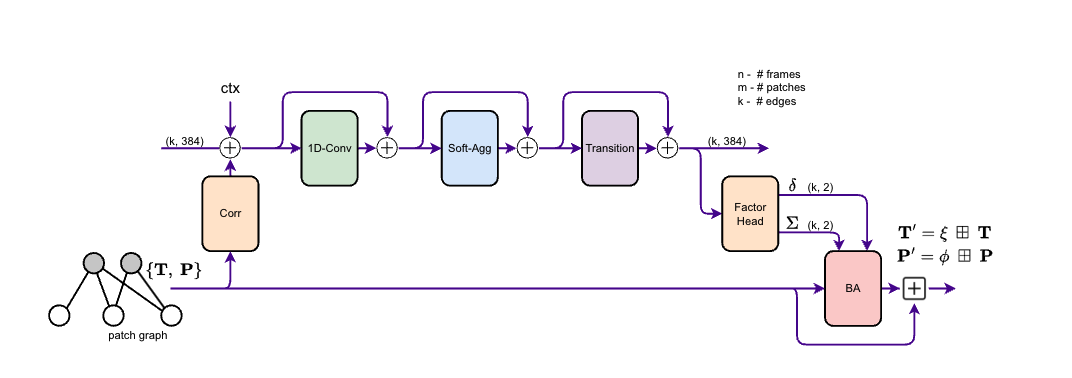

Figure 1 - Architecture of the DPVO deep learning framework. 

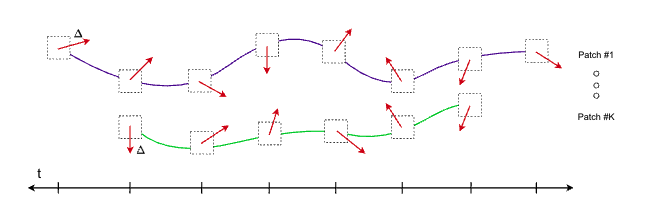

Figure 2 - Illustration of tracking based on patches.


## 1) Build the Conda Environment [~7 min]
*   Installing Conda
*   Downloading the library called DPVO 


**`Note: (Please make sure to save your data before disconnecting from your runtime as everything is stored in temporary cloud spaces)`**




In [ ]:
# Install conda
!pip install -q condacolab
from shutil import which
import condacolab
if which("conda") is None:
  condacolab.install()

In [ ]:
!git clone --recursive https://github.com/princeton-vl/DPVO
%cd /content/DPVO
!conda env create -f environment.yml
!mkdir -p old_ITC_2nd_floor

## 2) Install DPVO and dependencies [~16 min]

### Note: Meanwhile, let's download the video file and ground truth 3D point cloud data and place them inside the folder called "old_ITC_2nd_floor"
*   Video - https://surfdrive.surf.nl/files/index.php/s/KZ0HcRPvvnkORE0
*   3D point cloud (ground truth) - https://surfdrive.surf.nl/files/index.php/s/StxixhnugH0hqOI

In [ ]:
%cd /content/DPVO
!wget https://gitlab.com/libeigen/eigen/-/archive/3.4.0/eigen-3.4.0.zip
!unzip eigen-3.4.0.zip -d thirdparty
!conda install -c conda-forge poppler # for visualization
!pip install open3d evo pdf2image # for visualization
!source activate dpvo && \
conda install ipykernel -y && \
pip install .

# Download model weights and sample data
!wget https://www.dropbox.com/s/v0d5hsknsb2poa6/TartanAir.pickle && mv TartanAir.pickle datasets/
!wget https://www.dropbox.com/s/nap0u8zslspdwm4/models.zip && unzip models.zip


## 3) Configure and run DPVO


1.   Configure intrinsic camera calibration parameters - create the new file named `realsense.txt` inside the `calib` folder and **enter fx, fy, cx, and cy values in a single row separated with spaces** - `fx fy cx cy`. The provided video is recorded using the Realsense D435i sensor, and the intrinsic parameters are listed below. 

* Camera.fx: 612.5659179
* Camera.fy: 611.7391967
* Camera.cx: 417.6900329
* Camera.cy: 243.9552154


2.   Open the `config/default.yaml` file and observe the initial configuration. This is the file where you can specify the number of patches and other parameters. 
```
# VO config (increase for better accuracy)
PATCHES_PER_FRAME: 96
REMOVAL_WINDOW: 22
OPTIMIZATION_WINDOW: 10
PATCH_LIFETIME: 13
```

### Note: On Google Colab, DPVO with `--stride=5` runs at ~23-FPS




In [ ]:
!source activate dpvo && python demo.py --save_reconstruction --save_trajectory --plot --imagedir=old_ITC_2nd_floor/{video_file_name} --calib=calib/{calib_file_name} --stride=5

## 4) Visualize Trajectory Plot

In [ ]:
MOVIE_FILE = "old_ITC_2nd_floor/{video_file_name}"

import plotly.graph_objects as go
import open3d as o3d
import numpy as np
from evo.tools import file_interface
from pathlib import Path
from pdf2image import convert_from_path
stem = Path(MOVIE_FILE).stem
input_file = f"{stem}.ply"
poses_file = f"saved_trajectories/{stem}.txt"
trajectory_plots = f"trajectory_plots/{stem}.pdf"
images = convert_from_path(trajectory_plots, 100)
images[0].show()

## 5) Visualize 3D Point Cloud + 3D Trajectory Plot

In [ ]:
traj = file_interface.read_tum_trajectory_file(poses_file)
poses = traj.positions_xyz
pcd = o3d.io.read_point_cloud(input_file)
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

# Remove Outliers (Feel free to comment-out)
trajectory_center = np.median(poses, axis=0)
radii = lambda a: np.linalg.norm(a - trajectory_center, axis=1)
inlier_mask = radii(points) < radii(poses).max() * 10
points = points[inlier_mask]
colors = colors[inlier_mask]
print(f"Note: {((~inlier_mask).sum() * 100)/inlier_mask.size:.02f}% of outlier points removed.")

print("""
Controls:
---------
Zoom:      Scroll Wheel
Translate: Right-Click + Drag
Rotate:    Left-Click + Drag
""")

fig = go.Figure(
    data=[
        go.Scatter3d(x=poses[:,0], y=poses[:,1],z=poses[:,2], mode='lines'),
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(range=np.percentile(points[:,0], [1,99]).tolist()),
            yaxis=dict(range=np.percentile(points[:,1], [1,99]).tolist()),
            zaxis=dict(range=np.percentile(points[:,2], [1,99]).tolist())
        )
    )
)
fig.show()

## 6) Code snippets for answering question 1 (if time permits within practical session)- compare the generated point cloud with ground truth data


1.   Read and register point clouds (ground truth and generated point clouds are not aligned, **Note: methods used to register point clouds are not within the scope of this practical**)
* Read point clouds / 3d mesh files
```
#import open3d as o3d
source = o3d.io.read_point_cloud(ground_truth)
target = o3d.io.read_point_cloud(ply_file)
```
* Preprocess the point clouds
```
source = source.voxel_down_sample(voxel_size=0.05)
target = target.voxel_down_sample(voxel_size=0.05)
source, _ = source.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
target, _ = target.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
```
* estimate normals
```
source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(source, o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))
target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(target, o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))
```
* Compute correspondences
```
threshold = 0.05
# Compute FPFH features
result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source, target, source_fpfh, target_fpfh, True,
        threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
```
* Apply transformation to register point clouds
```
source.transform(result.transformation)
```
2.   Calculate the mean distance error 

* Compute the mean distance between the two point clouds
```
distances = source.compute_point_cloud_distance(target)
distances_np = np.asarray(distances)
mean_distance = distances_np.mean()
```

3. Plot the registered point clouds in the same plot (You could follow Step 5)

4. What would you expect by increasing the number of patches used to track the movement considering the following aspects
* performance of the algorithm
* Accuracy of the estimated 3d map





## 7) Preproccesed data for EoRoC - V01_01_easy data set 

Left Camera image video - https://surfdrive.surf.nl/files/index.php/s/POkSA38O6zGLNHi

Point cloud (ground truth) - https://surfdrive.surf.nl/files/index.php/s/7qr2ojscO458skk

Odometry information - https://surfdrive.surf.nl/files/index.php/s/BeSlda7wiomLLX9

Camera Calibration - It is already avaialable under `DPVO/calib/euroc.txt`

Algorithm Config - Available under `DPVO/config/default.yaml`